In [1]:
import pandas as pd

import sys
sys.path.append('..') 

from src.eda import (
    plot_features, 
    show_missing, 
    survival_rate_by_feature,
    plot_correlation_matrix
)
from src.preprocessing import (
    fill_missing_values, 
    remove_numerical_outliers
)

from src.modeling import evaluate_model


# Load data
df = pd.read_csv('../data/train.csv')
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


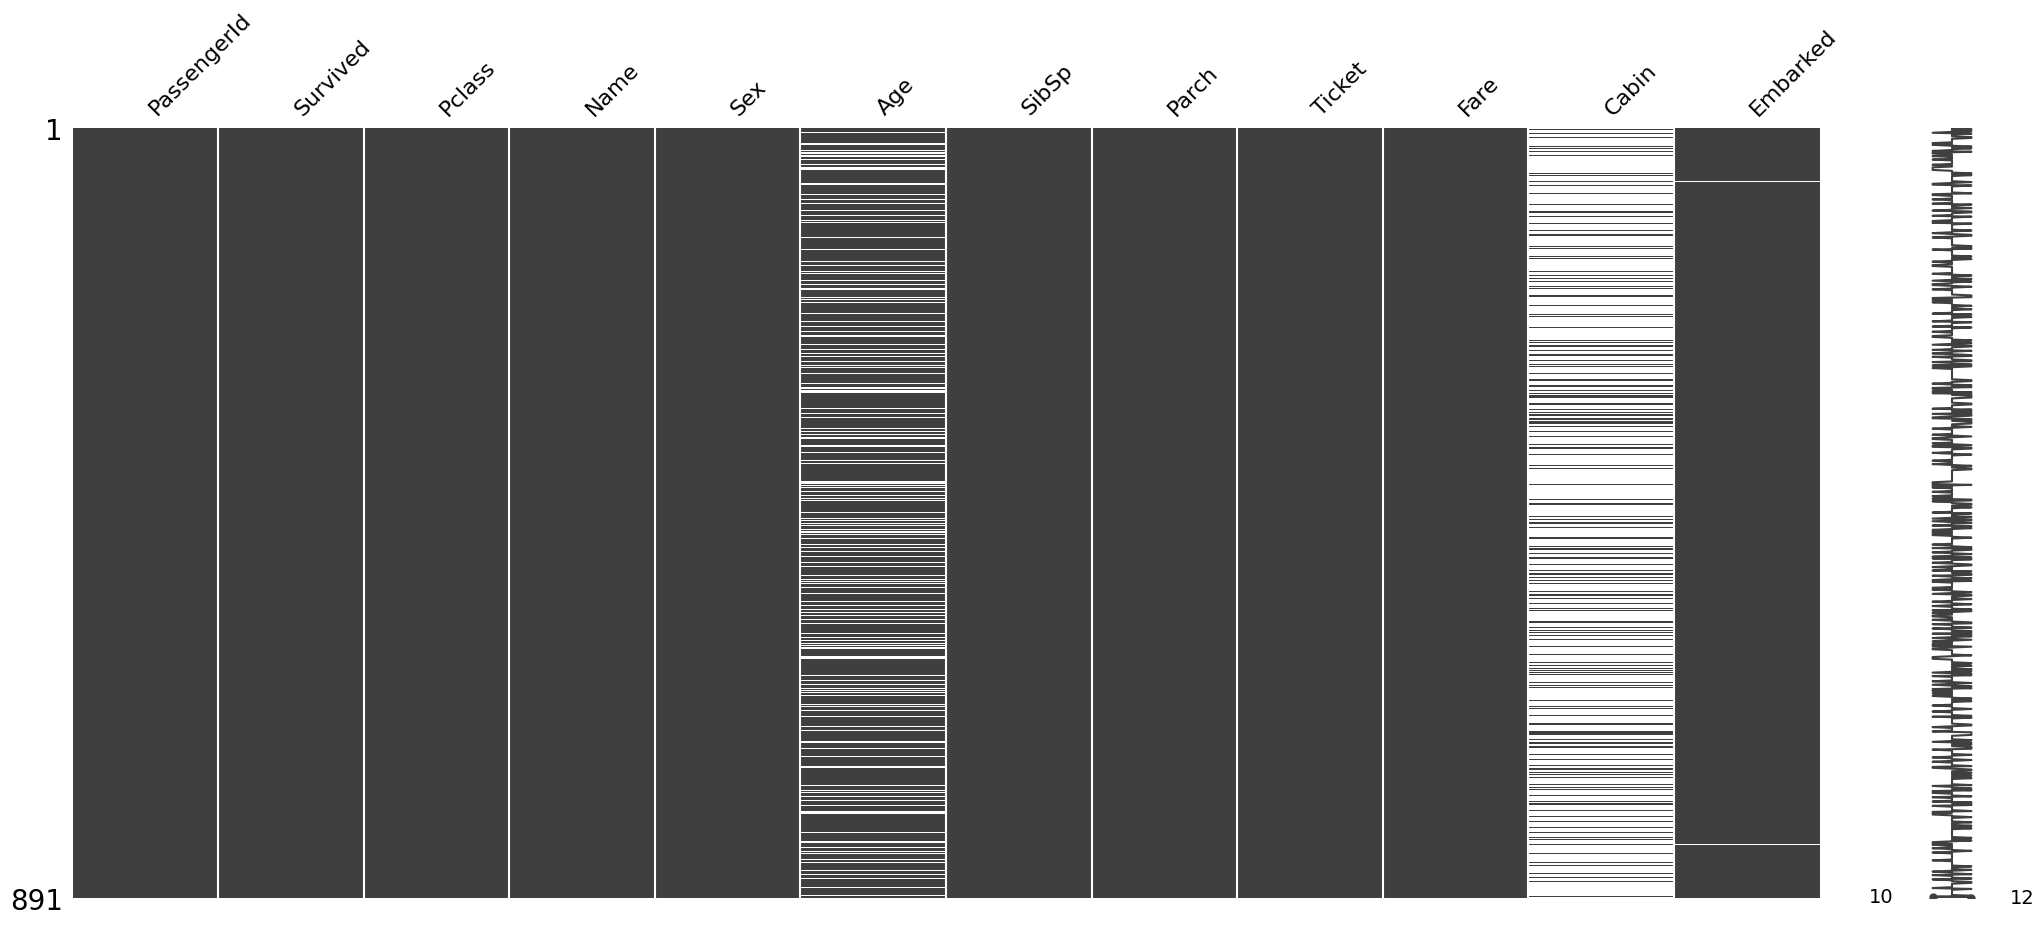

In [2]:
df.info()
df.describe()
df.isnull().sum()
show_missing(df)


In [3]:
df['Survived'] = df['Survived'].astype(int).map({1:'Yes', 0:'No'})
df['Embarked'] = df['Embarked'].map({'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'})
df['Pclass'] = df['Pclass'].astype(str)




📊 Plotting categorical feature: Sex


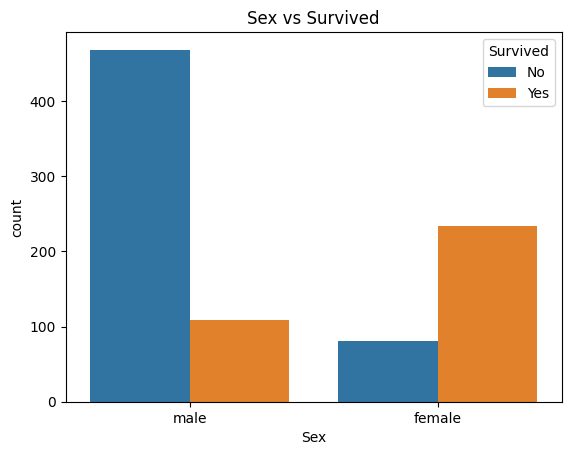

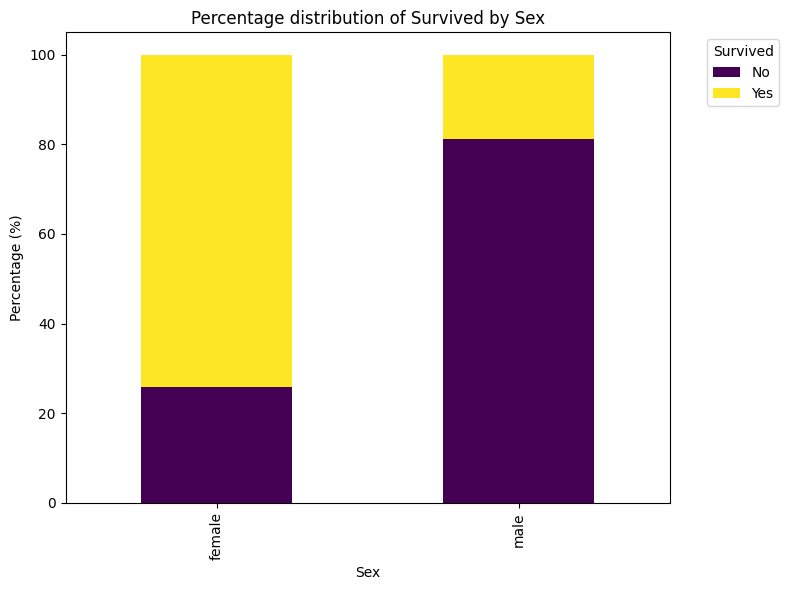

📊 Plotting categorical feature: Pclass


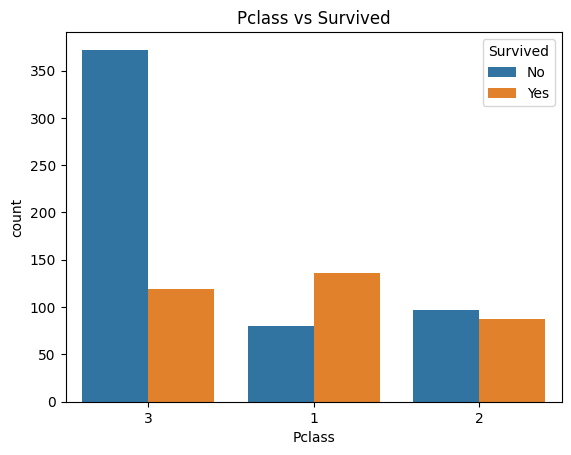

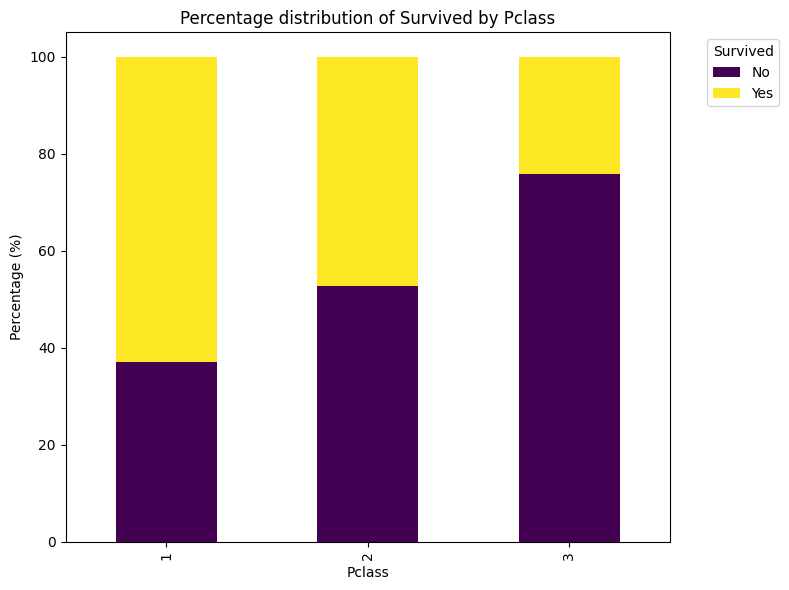

📊 Plotting categorical feature: Embarked


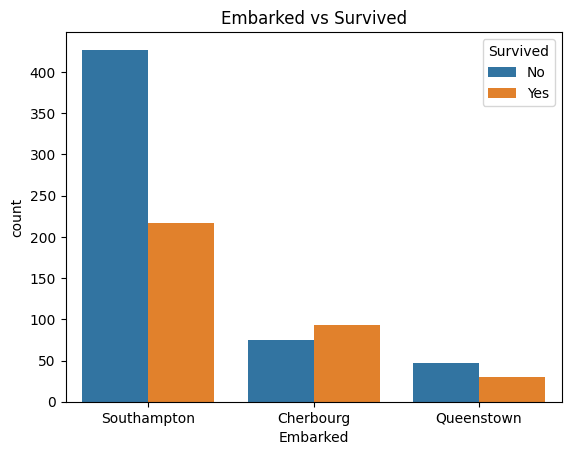

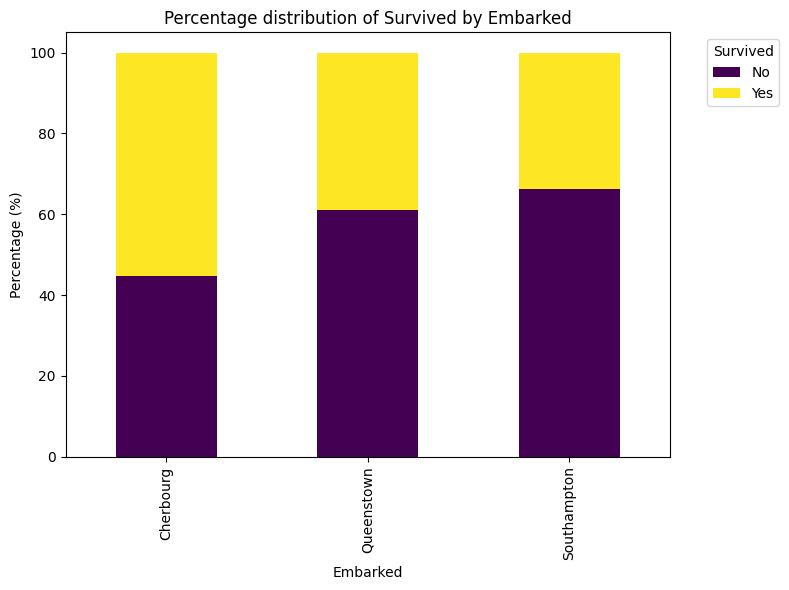

📈 Plotting numerical feature: Age


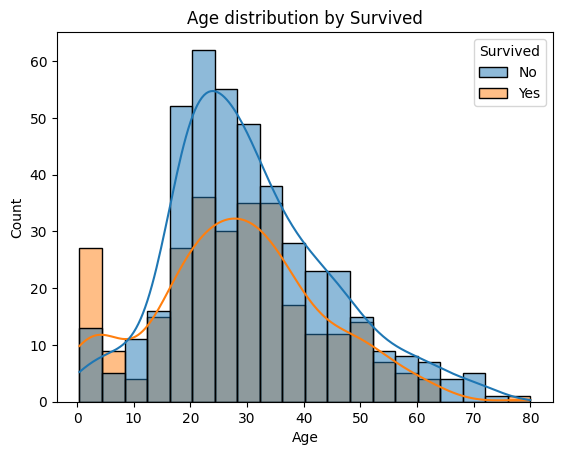

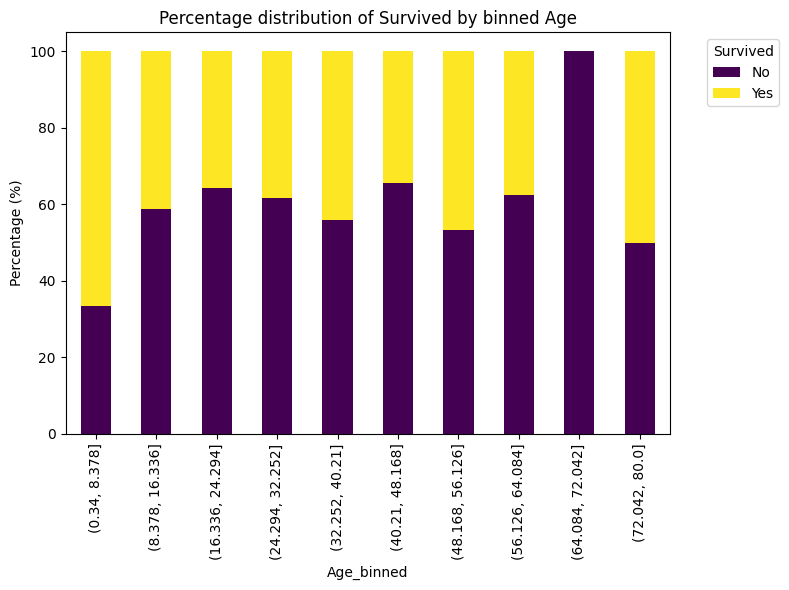

📈 Plotting numerical feature: Fare


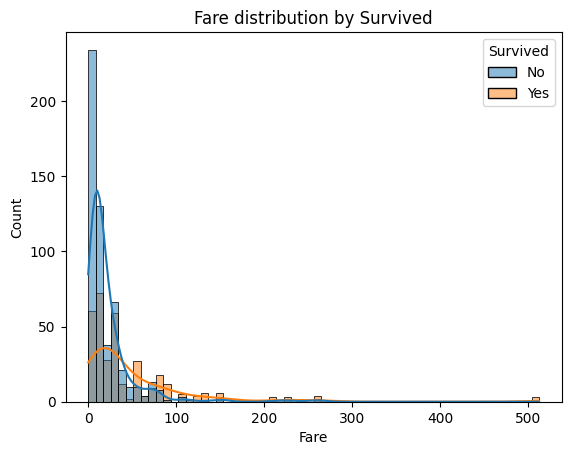

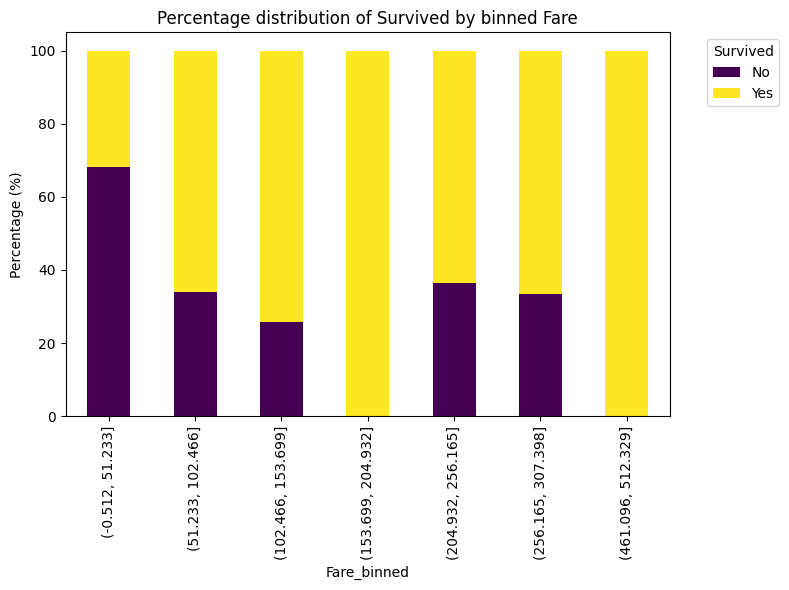

In [4]:
plot_features(df, ['Sex', 'Pclass', 'Embarked', 'Age', 'Fare'], 'Survived')

In [5]:
# plot_decision_tree(df, 'Survived', feature_col=None, max_depth=3, figsize=(10,8))
print(df)

     PassengerId Survived Pclass  \
0              1       No      3   
1              2      Yes      1   
2              3      Yes      3   
3              4      Yes      1   
4              5       No      3   
..           ...      ...    ...   
886          887       No      2   
887          888      Yes      1   
888          889       No      3   
889          890      Yes      1   
890          891       No      3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886           

C:\Users\zales\AppData\Local\Temp\ipykernel_20580\3874415504.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_features] = X[categorical_features].astype(str)


    Feature  Importance
0       Sex   57.052182
2    Pclass   15.722950
4      Fare    9.669550
3       Age    7.304830
5     SibSp    4.078769
6     Parch    3.830352
1  Embarked    2.341367


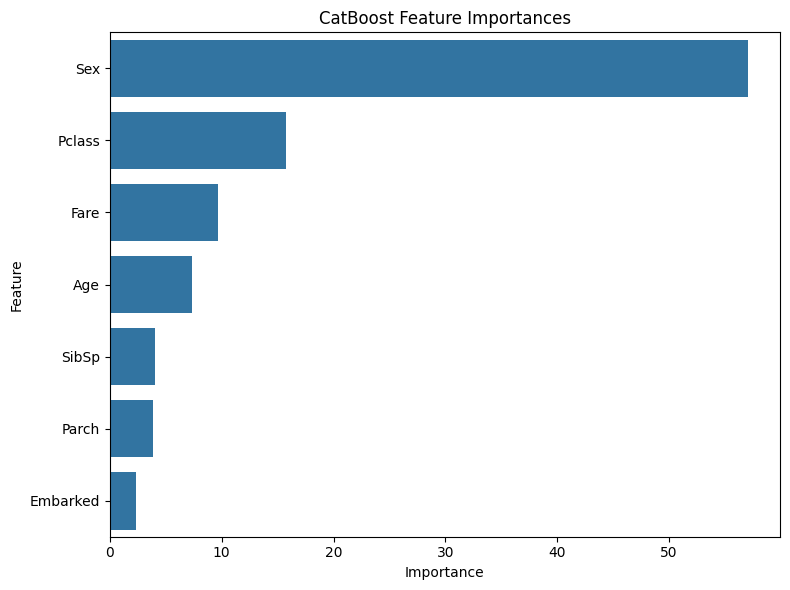

In [6]:
from catboost import CatBoostClassifier, Pool

# Define your categorical and numerical features
categorical_features = ['Sex', 'Embarked', 'Pclass']  # add any others
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']         # adjust as needed

# Create feature matrix and target
X = df[categorical_features + numerical_features]
y = df['Survived']

# Convert categorical columns to string just in case
X[categorical_features] = X[categorical_features].astype(str)

model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=3,
    cat_features=categorical_features,
    verbose=0,
    random_seed=42
)

model.fit(X, y)
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = model.get_feature_importance()
features = X.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display it
print(importance_df)
# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"])
plt.title("CatBoost Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


        count  sum
Sex               
female    314  233
male      577  109


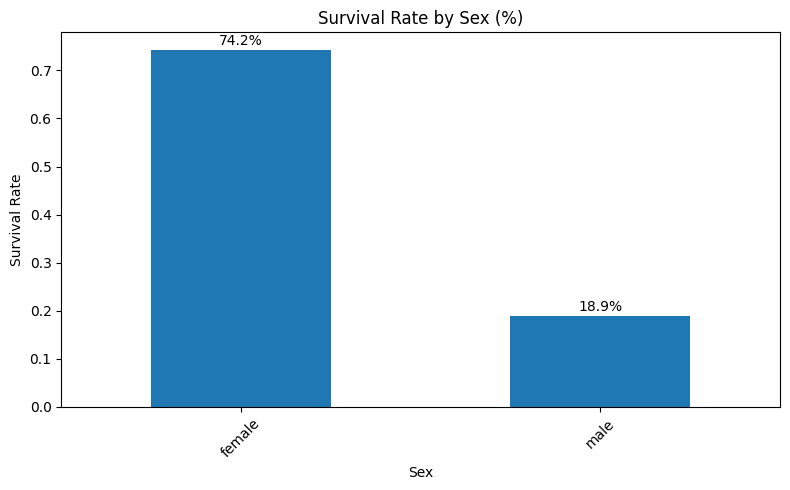

        count  sum
Pclass            
1         216  136
2         184   87
3         491  119


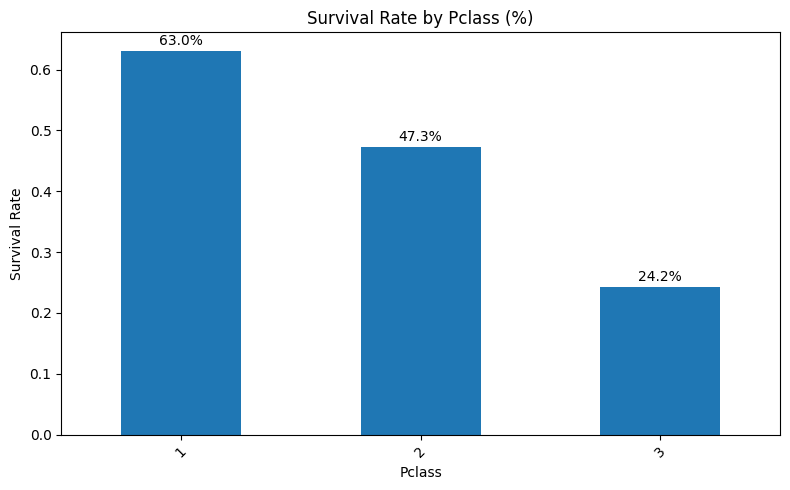

             count  sum
Embarked               
Cherbourg      168   93
Queenstown      77   30
Southampton    644  217


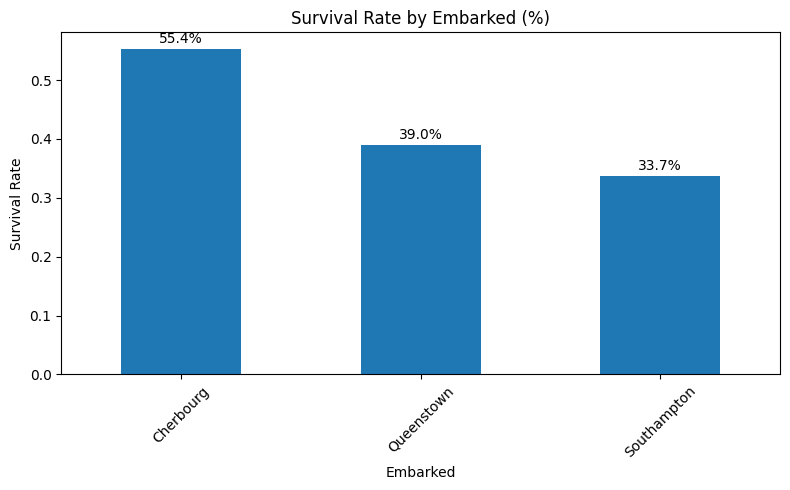

                 count  sum
Age_binned                 
(0.34, 20.315]     179   82
(20.315, 40.21]    385  153
(40.21, 60.105]    128   50
(60.105, 80.0]      22    5


c:\Users\zales\Documents\workspace\data science projects\titanic-survival-prediction\notebooks\..\src\eda.py:139: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(group_col)[target].agg(['count', 'sum'])


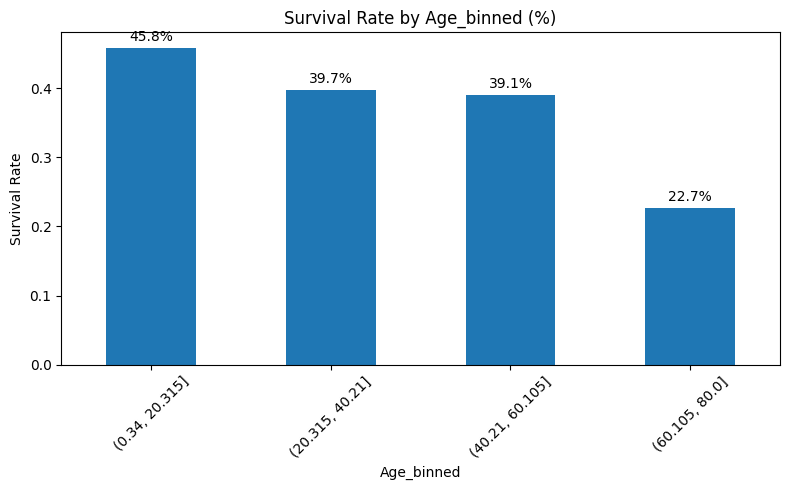

c:\Users\zales\Documents\workspace\data science projects\titanic-survival-prediction\notebooks\..\src\eda.py:139: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(group_col)[target].agg(['count', 'sum'])


                 count  sum
Fare_binned                
(-0.001, 7.91]     223   44
(7.91, 14.454]     224   68
(14.454, 31.0]     222  101
(31.0, 512.329]    222  129


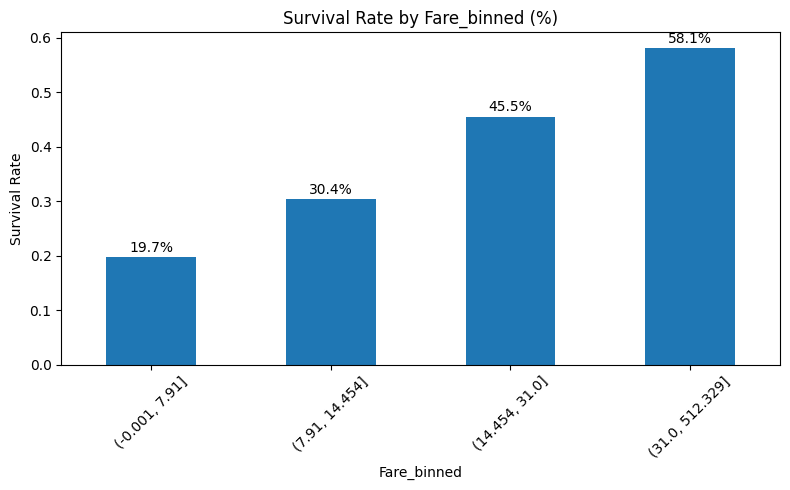

,count,sum,survival_rate
Fare_binned,,,
"(-0.001, 7.91]",223,44,0.197309
"(7.91, 14.454]",224,68,0.303571
"(14.454, 31.0]",222,101,0.454955
"(31.0, 512.329]",222,129,0.581081


In [7]:
df['Survived'] = df['Survived'].map({'Yes': 1, 'No': 0})

# # Categorical
survival_rate_by_feature(df, 'Sex')
survival_rate_by_feature(df, 'Pclass')
survival_rate_by_feature(df, 'Embarked')

# # Numerical (binned)
survival_rate_by_feature(df, 'Age', bins=4)
survival_rate_by_feature(df, 'Fare', bins=4, quantiles=True)

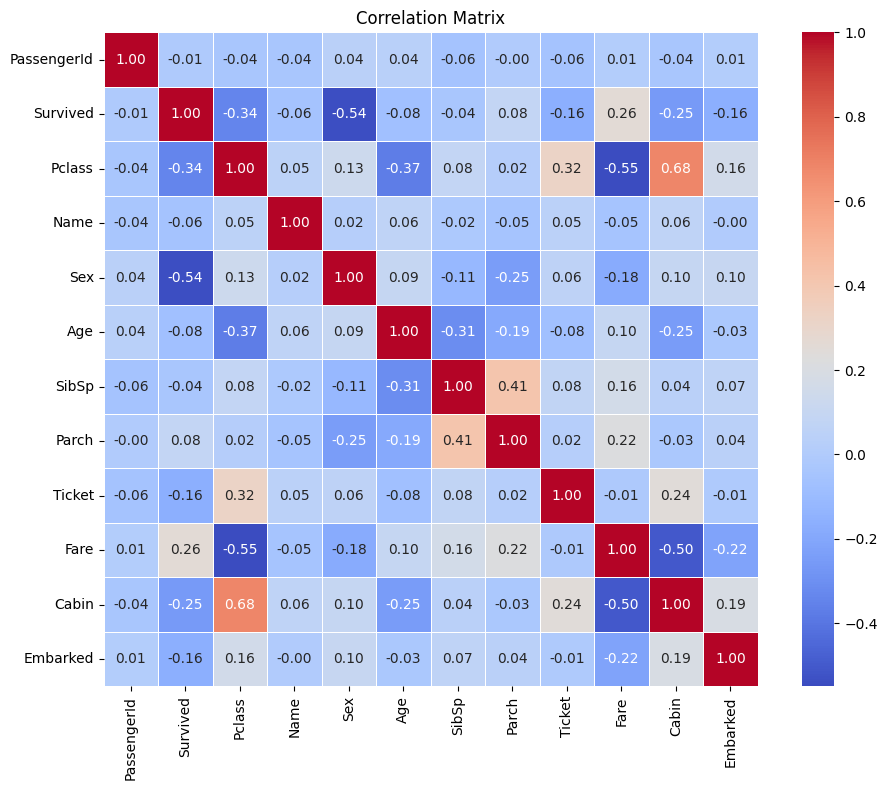

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,1.000000,-0.005007,-0.035144,-0.038559,0.042939,0.036847,-0.057527,-0.001652,-0.056554,0.012658,-0.035077,0.013083
Survived,-0.005007,1.000000,-0.338481,-0.057343,-0.543351,-0.077221,-0.035322,0.081629,-0.164549,0.257307,-0.254888,-0.163517
Pclass,-0.035144,-0.338481,1.000000,0.052831,0.131900,-0.369226,0.083081,0.018443,0.319869,-0.549500,0.684121,0.157112
Name,-0.038559,-0.057343,0.052831,1.000000,0.020314,0.062583,-0.017230,-0.049105,0.047348,-0.049173,0.061959,-0.004557
Sex,0.042939,-0.543351,0.131900,0.020314,1.000000,0.093254,-0.114631,-0.245489,0.059372,-0.182333,0.096681,0.104057
Age,0.036847,-0.077221,-0.369226,0.062583,0.093254,1.000000,-0.308247,-0.189119,-0.075934,0.096067,-0.252331,-0.025252
SibSp,-0.057527,-0.035322,0.083081,-0.017230,-0.114631,-0.308247,1.000000,0.414838,0.079461,0.159651,0.043593,0.066654
Parch,-0.001652,0.081629,0.018443,-0.049105,-0.245489,-0.189119,0.414838,1.000000,0.020003,0.216225,-0.028324,0.038322
Ticket,-0.056554,-0.164549,0.319869,0.047348,0.059372,-0.075934,0.079461,0.020003,1.000000,-0.013885,0.243696,-0.006041
Fare,0.012658,0.257307,-0.549500,-0.049173,-0.182333,0.096067,0.159651,0.216225,-0.013885,1.000000,-0.503355,-0.221226


In [8]:
plot_correlation_matrix(df)